# Mapzen geocoding analysis

The sample consists of 19,000 randomly addresses with a matched `parcel_id`

`SELECT * INTO mapzen_geocoded FROM incidentaddress WHERE parcel_id IS NOT null ORDER BY random() LIMIT 19000`

Data geocoded using the `mapzen_geocoder` script, and with different datasources
- OpenAddresses
- Who's on First
- OpenStreetMap
- Geonames
- All of the above

`parcel_id` populated using ST_WITHIN

`UPDATE mapzen_geocoded
    SET oa_parcel_id=p.parcel_id
    FROM parcel_risk_category_local p
    WHERE st_within(oa_geom, p.wkb_geometry)`

In [257]:
import psycopg2
import pandas as pd
import numpy as np
from IPython.display import display

# Set your service for nfirs production DB
POSTGRES_SERVICE = 'nfirs'

TABLE = 'mapzen_geocoded'

In [258]:
conn = psycopg2.connect(service=POSTGRES_SERVICE)

records = pd.read_sql("""
select * from (
    select * from select_mapzen_data('mapzen_', 'all', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('oa_', 'oa', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('wof_', 'wof', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('gn_', 'gn', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('osm_', 'osm', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('_', 'sanitized', 'exact', 'Not found') UNION ALL
    select * from select_mapzen_data('google_', 'google', 'ROOFTOP', 'Not found')
) data order by rooftop_hits  desc;
""".format(TABLE), conn)
# display(records)

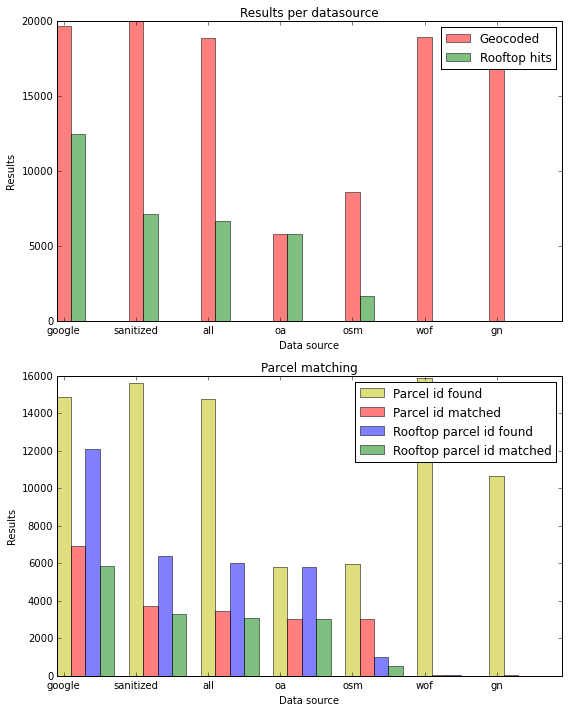

,datasource,geocoded,rooftop_hits,parcel_id_found,parcel_id_matched,rooftop_parcel_id_found,rooftop_parcel_id_matched
0,google,19685,12473,14872,6931,12099,5852
1,sanitized,19999,7142,15649,3704,6412,3300
2,all,18871,6692,14778,3475,6009,3103
3,oa,5844,5844,5785,3025,5785,3025
4,osm,8641,1648,5987,3020,1003,528
5,wof,18973,43,15900,62,38,0
6,gn,19151,27,10642,39,7,0


In [259]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 10))
index = np.arange(7)
bar_width = 0.2

opacity = 0.5

ax1.bar(index, records['geocoded'], 
                bar_width, color='r', label='Geocoded',
                alpha=opacity)
ax1.bar(index + bar_width, records['rooftop_hits'], 
                bar_width, color='g', label='Rooftop hits',
                alpha=opacity)
ax1.set_xlabel('Data source')
ax1.set_ylabel('Results')
ax1.set_title('Results per datasource')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(records['datasource'])
ax1.legend()


ax2.bar(index, records['parcel_id_found'],
                bar_width, color='y', label='Parcel id found',
               alpha=opacity)
ax2.bar(index + bar_width, records['parcel_id_matched'],
                bar_width, color='r', label='Parcel id matched',
               alpha=opacity)
ax2.bar(index + bar_width * 2, records['rooftop_parcel_id_found'],
                bar_width, color='b', label='Rooftop parcel id found',
               alpha=opacity)
ax2.bar(index + bar_width * 3, records['rooftop_parcel_id_matched'],
                bar_width, color='g', label='Rooftop parcel id matched',
               alpha=opacity)
ax2.set_xlabel('Data source')
ax2.set_ylabel('Results')
ax2.set_title('Parcel matching')
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(records['datasource'])
ax2.legend()



fig.tight_layout()


plt.show()
display(records[['datasource', 'geocoded', 'rooftop_hits', 'parcel_id_found', 'parcel_id_matched', 'rooftop_parcel_id_found', 'rooftop_parcel_id_matched']])